### A `tensorflow` based model for image classification

2023-06-24
Chris Hamm
On flight DL 703

In [69]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 60

Autosaving every 60 seconds


In [56]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import os
import shutil
import cv2

np.random.seed(1138)

In [ ]:
# classes = ['Nar', 'Nmi', 'Nfr', 'Nhe']

In [39]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tf_explain.core.grad_cam import GradCAM

In [4]:
# Define the main directory containing the butterfly species folders
main_directory = '/Users/Chris/Projects/MSB_Morphometrics/Neonympha_morphometrics/data/images/Museum'

In [5]:
# Define the image dimensions and batch size
image_width, image_height = 224, 224
batch_size = 32

In [6]:
# Create data generators for loading and augmenting the images
datagen = ImageDataGenerator(
    rescale=1.0/255,  # Rescale pixel values between 0 and 1
    shear_range=0.2,  # Apply random shear transformations
    zoom_range=0.2,  # Apply random zoom transformations
    horizontal_flip=True,  # Flip images horizontally
    rotation_range=45,  # Randomly rotate the images
    width_shift_range=0.1,  # Randomly shift the images horizontally
    height_shift_range=0.1,  # Randomly shift the images vertically
    brightness_range=[0.8, 1.2],  # Randomly adjust the brightness
    fill_mode='nearest'
)

In [16]:
# Load and augment the images from the main directory
generator = datagen.flow_from_directory(
    main_directory,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 456 images belonging to 4 classes.


In [17]:
# Split the images into train, validation, and test sets
train_data, test_data, train_labels, test_labels = train_test_split(
    generator.filenames,
    generator.labels,
    test_size=0.2,  # Adjust the test size as desired
    random_state=42
)

train_data, validation_data, train_labels, validation_labels = train_test_split(
    train_data,
    train_labels,
    test_size=0.2,  # Adjust the validation size as desired
    random_state=42
)

In [19]:
# Create a new directory to store the train, validation, and test sets
new_directory = '/Users/Chris/Projects/MSB_Morphometrics/Neonympha_morphometrics/data/images/train_test_validate'
os.makedirs(new_directory, exist_ok=True)

# Create separate directories for train, validation, and test sets within the new directory
train_directory = os.path.join(new_directory, 'train')
validation_directory = os.path.join(new_directory, 'validation')
test_directory = os.path.join(new_directory, 'test')

os.makedirs(train_directory, exist_ok=True)
os.makedirs(validation_directory, exist_ok=True)
os.makedirs(test_directory, exist_ok=True)

In [24]:
# Copy the images to their respective directories in the new location
for filename, label in zip(train_data, train_labels):
    src_path = os.path.join(main_directory, filename)
    class_name = train_generator.class_indices
    class_name = list(class_name.keys())[list(class_name.values()).index(label)]
    dst_path = os.path.join(train_directory, class_name, os.path.basename(filename))
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    shutil.copy(src_path, dst_path)

for filename, label in zip(validation_data, validation_labels):
    src_path = os.path.join(main_directory, filename)
    class_name = train_generator.class_indices
    class_name = list(class_name.keys())[list(class_name.values()).index(label)]
    dst_path = os.path.join(validation_directory, class_name, os.path.basename(filename))
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    shutil.copy(src_path, dst_path)

for filename, label in zip(test_data, test_labels):
    src_path = os.path.join(main_directory, filename)
    class_name = train_generator.class_indices
    class_name = list(class_name.keys())[list(class_name.values()).index(label)]
    dst_path = os.path.join(test_directory, class_name, os.path.basename(filename))
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    shutil.copy(src_path, dst_path)

In [25]:
# Load and augment the training set images
# Create data generators for training, validation, and test sets
train_generator = datagen.flow_from_directory(
    train_directory,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 456 images belonging to 4 classes.


In [27]:
# Load the validation set images
validation_generator = datagen.flow_from_directory(
    validation_directory,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 73 images belonging to 4 classes.


In [28]:
test_generator = datagen.flow_from_directory(
    test_directory,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 92 images belonging to 4 classes.


In [29]:
# Create a dictionary mapping class indices to butterfly species names
class_names = train_generator.class_indices
class_names = dict((v, k) for k, v in class_names.items())

In [30]:
# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_width, image_height, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

In [31]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
# Train the model and store the training history
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=10,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size)

Epoch 1/10
14/14 [==============================] - 16s 1s/step - loss: 1.3565 - accuracy: 0.4693 - val_loss: 1.3216 - val_accuracy: 0.3750
Epoch 2/10
14/14 [==============================] - 15s 1s/step - loss: 1.1148 - accuracy: 0.5047 - val_loss: 0.9590 - val_accuracy: 0.4375
Epoch 3/10
14/14 [==============================] - 15s 1s/step - loss: 0.9076 - accuracy: 0.5637 - val_loss: 0.9884 - val_accuracy: 0.4688
Epoch 4/10
14/14 [==============================] - 15s 1s/step - loss: 0.7938 - accuracy: 0.6321 - val_loss: 0.7902 - val_accuracy: 0.6875
Epoch 5/10
14/14 [==============================] - 15s 1s/step - loss: 0.7653 - accuracy: 0.6533 - val_loss: 0.8226 - val_accuracy: 0.6562
Epoch 6/10
14/14 [==============================] - 15s 1s/step - loss: 0.6902 - accuracy: 0.6698 - val_loss: 0.6416 - val_accuracy: 0.7344
Epoch 7/10
14/14 [==============================] - 15s 1s/step - loss: 0.6569 - accuracy: 0.7028 - val_loss: 0.6154 - val_accuracy: 0.7500
Epoch 8/10
14/14 [==

In [ ]:
# Save the trained model
model.save('neonympha_species_model_tf1.h5')

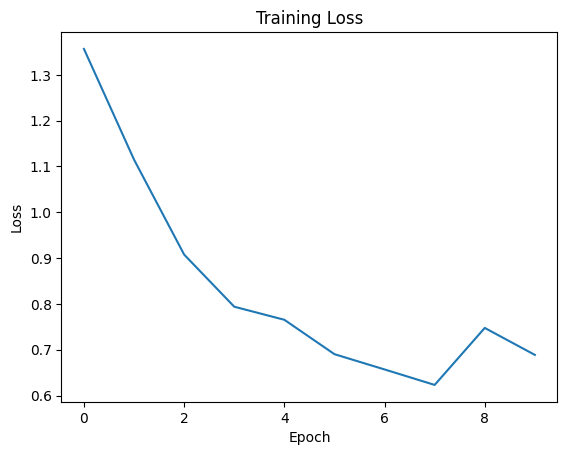

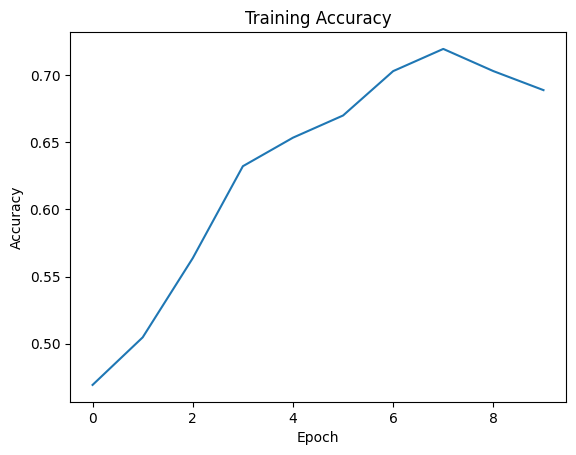

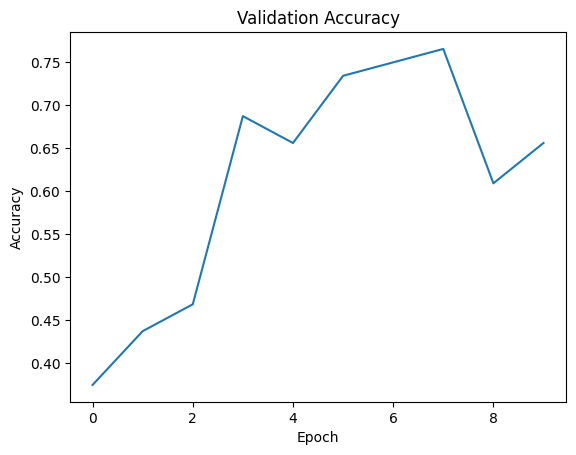

In [33]:
# Visualize the training loss
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Visualize the training accuracy
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Visualize the validation accuracy
plt.plot(history.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [34]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

3/3 [==============================] - 3s 925ms/step - loss: 0.6987 - accuracy: 0.6957
Test Loss: 0.6987
Test Accuracy: 0.6957


Using `resnet`

In this code, the following improvements have been made:

1. Model architecture: The model now incorporates a pre-trained ResNet50 backbone followed by a Global Average Pooling layer. This allows the model to leverage the powerful feature extraction capabilities of ResNet50.

1. Regularization: Dropout layers with a dropout rate of 0.5 have been added to reduce overfitting.

1. Freezing pre-trained layers: The pre-trained ResNet50 layers are frozen to prevent them from being trained, preserving the pre-learned features.

1. Increased number of epochs: The model is trained for 20 epochs to allow more training time.

In [35]:
# Build the neural network model
model2 = tf.keras.Sequential([
    tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(image_width, image_height, 3)),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Freeze the pre-trained layers
model2.layers[0].trainable = False

# Compile the model
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history2 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

94765736/94765736 [==============================] - 62s 1us/step
Epoch 1/20
14/14 [==============================] - 16s 1s/step - loss: 0.6883 - accuracy: 0.6816 - val_loss: 0.6486 - val_accuracy: 0.7812
Epoch 2/20
14/14 [==============================] - 16s 1s/step - loss: 0.6014 - accuracy: 0.7453 - val_loss: 0.5019 - val_accuracy: 0.8281
Epoch 3/20
14/14 [==============================] - 15s 1s/step - loss: 0.5811 - accuracy: 0.7594 - val_loss: 0.5244 - val_accuracy: 0.7812
Epoch 4/20
14/14 [==============================] - 16s 1s/step - loss: 0.5198 - accuracy: 0.7665 - val_loss: 0.5292 - val_accuracy: 0.7969
Epoch 5/20
14/14 [==============================] - 15s 1s/step - loss: 0.5027 - accuracy: 0.7759 - val_loss: 0.4498 - val_accuracy: 0.8281
Epoch 6/20
14/14 [==============================] - 15s 1s/step - loss: 0.4446 - accuracy: 0.7972 - val_loss: 0.4389 - val_accuracy: 0.8281
Epoch 7/20
14/14 [==============================] - 15s 1s/step - loss: 0.4694 - accuracy: 0.7

In [ ]:
# Save the trained model
model.save('improved_neonympha_species_model.h5')

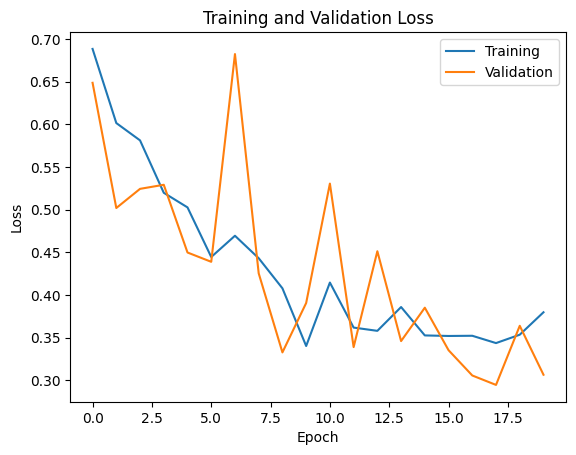

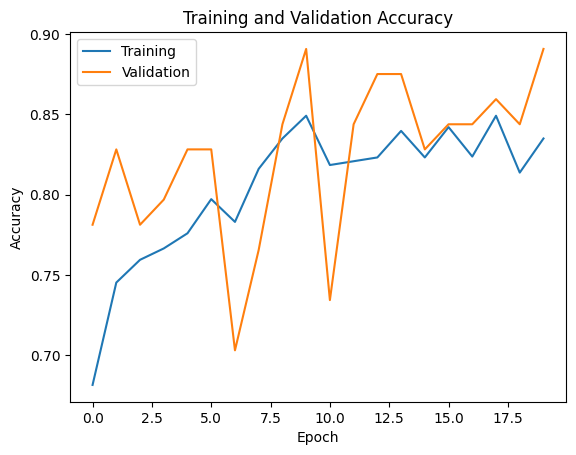

In [42]:
# Visualize the training and validation loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.show()

# Visualize the training and validation accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.show()

### Now I want to see what layers are seeing what to make distinctions among species


In [51]:
# Visualize the important components of the images using Grad-CAM
# Select a sample image for visualization
sample_image = '/Users/Chris/Projects/MSB_Morphometrics/Neonympha_morphometrics/data/images/Museum/Nmi/Nmi_NJ108.JPG'
img = tf.keras.preprocessing.image.load_img(sample_image, target_size=(image_width, image_height))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, axis=0)
img_array /= 255.0

# Choose the target class index for visualization (0: Neonympha mitchellii, 1: N. francisii, 2: N. areaolata, 3: N. helicta)
target_class_index = 0

# Create a Grad-CAM explainer
explainer = GradCAM()

# Get the available layer names in the model
layer_names = [layer.name for layer in model2.layers]

# Choose an appropriate layer for visualization
layer_name = layer_names[-3]  # Choose the third-to-last layer

In [52]:
layer_name

'dense_2'

In [55]:
# Generate the Grad-CAM heatmap
heatmap = explainer.explain(
    validation_data=(img_array, None),
    model=model,
    class_index=target_class_index,
    layer_name='conv2d_3'
)

# Modify the heatmap_display function
def heatmap_display(heatmap, original_image, colormap, image_weight):
    heatmap = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))
    heatmap = cv2.applyColorMap(
        cv2.cvtColor((heatmap * 255).astype("uint8"), cv2.COLOR_GRAY2BGR), colormap
    )
    image = cv2.cvtColor(np.uint8(original_image * 255), cv2.COLOR_RGB2BGR)
    superimposed_image = cv2.addWeighted(image, image_weight, heatmap, 1 - image_weight, 0)
    return superimposed_image


# Plot the original image and Grad-CAM heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(img)
ax1.axis('off')
ax1.set_title('Original Image')

ax2.imshow(img)
ax2.imshow(heatmap, cmap='jet', alpha=0.5)
ax2.axis('off')
ax2.set_title('Grad-CAM Heatmap')

plt.tight_layout()
plt.show()

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'min'

In [62]:
# Get the output activation for the target class
preds = model2.predict(img_array)
target_activation = preds[:, target_class_index]

# Get the last convolutional layer's output
last_conv_layer = model2.get_layer('dense_3')

# Calculate the gradient of the target class with respect to the output feature map of the last convolutional layer
grad_model = tf.keras.models.Model([model2.inputs], [model2.get_layer('dense_3').output, model2.output])
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array)
    loss = predictions[:, target_class_index]
grads = tape.gradient(loss, conv_outputs)[0]

# Compute the CAM by multiplying each channel in the feature map by the gradient importance and taking the mean
cams = tf.reduce_mean(tf.multiply(grads, conv_outputs), axis=-1)

# Normalize the CAM
cams = np.maximum(cams, 0)
cams /= np.max(cams)

# Reshape the CAM array to have an additional dimension
cams = np.expand_dims(cams, axis=-1)

# Resize the CAM to match the input image size
cams = tf.image.resize(cams, (image_height, image_width)).numpy()[0, :, :, 0]

# Overlay the CAM on the original image
heatmap = cv2.applyColorMap(np.uint8(255 * cams), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
superimposed_img = cv2.addWeighted(np.uint8(255 * img_array[0]), 0.5, heatmap, 0.5, 0)


# Plot the original image and the CAM
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(img)
ax1.axis('off')
ax1.set_title('Original Image')

ax2.imshow(superimposed_img)
ax2.axis('off')
ax2.set_title('Class Activation Map (CAM)')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 73ms/step


ValueError: 'images' must have either 3 or 4 dimensions.

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'") at layer "conv1_pad". The following previous layers were accessed without issue: []

In [67]:

# Get the activation maps from intermediate layers
layer_outputs = [layer.output for layer in model2.layers]
activation_model = tf.keras.models.Model(inputs=model2.input, outputs=layer_outputs)
activations = activation_model.predict(img_array)

# Visualize the activation maps
fig, axes = plt.subplots(len(activations), 1, figsize=(8, 8 * len(activations)))
for i, activation in enumerate(activations):
    axes[i].imshow(activation[0, :, :, 0], cmap='jet')
    axes[i].axis('off')
    axes[i].set_title(f'Layer {i+1} Activation')
plt.tight_layout()
plt.show()

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'") at layer "conv1_pad". The following previous layers were accessed without issue: []

In [68]:

# Get the activation maps from intermediate layers
layer_outputs = [layer.output for layer in model2.layers]
activation_model = tf.keras.models.Model(inputs=model2.input, outputs=layer_outputs)
activations = activation_model.predict(img_array)

# Visualize the activation maps
fig, axes = plt.subplots(len(activations), 1, figsize=(8, 8 * len(activations)))
for i, activation in enumerate(activations):
    axes[i].imshow(activation[0, :, :, 0], cmap='jet')
    axes[i].axis('off')
    axes[i].set_title(f'Layer {i+1} Activation')
plt.tight_layout()
plt.show()

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'") at layer "conv1_pad". The following previous layers were accessed without issue: []